# An Exploration of Covid-19 in Malaysia

The following datasets will be used:
1. cases_malaysia.csv
2. cases_state.csv
3. clusters.csv
4. deaths_malaysia.csv
5. deaths_state.csv
6. hospital.csv
7. icu.csv
8. pkrc.csv
9. tests_malaysia.csv
10. tests_state.csv

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [3]:
cases_malaysia = pd.read_csv('./cases/epidemic/cases_malaysia.csv')
cases_state = pd.read_csv('./cases/epidemic/cases_state.csv')
clusters = pd.read_csv('./cases/epidemic/clusters.csv')
deaths_malaysia = pd.read_csv('./cases/epidemic/deaths_malaysia.csv')
deaths_state = pd.read_csv('./cases/epidemic/deaths_state.csv')
hospital = pd.read_csv('./cases/epidemic/hospital.csv')
icu = pd.read_csv('./cases/epidemic/icu.csv')
pkrc = pd.read_csv('./cases/epidemic/pkrc.csv')
tests_malaysia = pd.read_csv('./cases/epidemic/tests_malaysia.csv')
tests_state = pd.read_csv('./cases/epidemic/tests_state.csv') 
vax_malaysia = pd.read_csv('./vaccination/vaccination/vax_malaysia.csv') 
vax_state = pd.read_csv('./vaccination/vaccination/vax_state.csv') 
vaxreg_malaysia = pd.read_csv('./vaccination/registration/vaxreg_malaysia.csv') 
vaxreg_state = pd.read_csv('./vaccination/registration/vaxreg_state.csv') 
population = pd.read_csv('./vaccination/static/population.csv') 

## EDA and Pre-processing
1. Restructure dataset format by melting/pivot table
2. Deal with missing values and outliers (missing values will be dropped and outliers will be checked on case-by-case basis)

### Cases Malaysia

In [4]:
cases_malaysia

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,2020-01-25,4,4,0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-26,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-27,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-28,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-29,3,3,0,7,0.0,0.0,0.0,1.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,2021-10-05,8817,14,15615,135685,619.0,1062.0,5106.0,1386.0,686.0,5624.0,1007.0,0.0,0.0,199.0,30.0,10.0,3.0,377.0
620,2021-10-06,9380,13,13045,131981,426.0,1044.0,5338.0,1656.0,752.0,5877.0,1024.0,0.0,2.0,147.0,35.0,6.0,2.0,234.0
621,2021-10-07,9890,18,12884,128974,697.0,1147.0,5647.0,1731.0,766.0,6167.0,1164.0,0.0,0.0,240.0,111.0,41.0,5.0,300.0
622,2021-10-08,9751,15,12724,125999,382.0,1033.0,5687.0,1728.0,757.0,6033.0,1132.0,0.0,0.0,157.0,17.0,16.0,8.0,184.0


In [5]:
cases_malaysia.isna().sum()

date                         0
cases_new                    0
cases_import                 0
cases_recovered              0
cases_active                 0
cases_cluster                1
cases_pvax                   1
cases_fvax                   1
cases_child                  1
cases_adolescent             1
cases_adult                  1
cases_elderly                1
cluster_import             342
cluster_religious          342
cluster_community          342
cluster_highRisk           342
cluster_education          342
cluster_detentionCentre    342
cluster_workplace          342
dtype: int64

In [6]:
cases_malaysia.drop_duplicates()

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,2020-01-25,4,4,0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-26,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-27,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-28,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-29,3,3,0,7,0.0,0.0,0.0,1.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,2021-10-05,8817,14,15615,135685,619.0,1062.0,5106.0,1386.0,686.0,5624.0,1007.0,0.0,0.0,199.0,30.0,10.0,3.0,377.0
620,2021-10-06,9380,13,13045,131981,426.0,1044.0,5338.0,1656.0,752.0,5877.0,1024.0,0.0,2.0,147.0,35.0,6.0,2.0,234.0
621,2021-10-07,9890,18,12884,128974,697.0,1147.0,5647.0,1731.0,766.0,6167.0,1164.0,0.0,0.0,240.0,111.0,41.0,5.0,300.0
622,2021-10-08,9751,15,12724,125999,382.0,1033.0,5687.0,1728.0,757.0,6033.0,1132.0,0.0,0.0,157.0,17.0,16.0,8.0,184.0


In [7]:
# cluster columns are irrelevant, remove them
cases_malaysia.drop(columns=['cluster_import', 'cluster_religious', 'cluster_community', 'cluster_highRisk', 'cluster_education', 'cluster_detentionCentre', 'cluster_workplace'], inplace=True)
# other dates with a null value, just drop that row
cases_malaysia.fillna(0, inplace=True)
cases_malaysia.head()

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
0,2020-01-25,4,4,0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2020-01-26,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-27,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-28,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-29,3,3,0,7,0.0,0.0,0.0,1.0,0.0,2.0,0.0


### Cases State

In [8]:
cases_state

,date,state,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
0,2020-01-25,Johor,4,4,0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2020-01-25,Kedah,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-25,Kelantan,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,Melaka,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-25,Negeri Sembilan,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,2021-10-09,Selangor,1351,2,2271,16168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9980,2021-10-09,Terengganu,590,0,1098,6641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9981,2021-10-09,W.P. Kuala Lumpur,288,5,297,3286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9982,2021-10-09,W.P. Labuan,1,0,1,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
cases_state.isna().sum()

date                 0
state                0
cases_new            0
cases_import         0
cases_recovered      0
cases_active         0
cases_cluster       16
cases_pvax          16
cases_fvax          16
cases_child         16
cases_adolescent    16
cases_adult         16
cases_elderly       16
dtype: int64

In [10]:
cases_state.drop_duplicates()

,date,state,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
0,2020-01-25,Johor,4,4,0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2020-01-25,Kedah,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-25,Kelantan,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,Melaka,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-25,Negeri Sembilan,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,2021-10-09,Selangor,1351,2,2271,16168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9980,2021-10-09,Terengganu,590,0,1098,6641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9981,2021-10-09,W.P. Kuala Lumpur,288,5,297,3286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9982,2021-10-09,W.P. Labuan,1,0,1,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
cases_state.fillna(0, inplace=True)

In [12]:
cases_state_pivoted = cases_state.pivot(index='date', columns='state', values='cases_new')
cases_state_pivoted.head()

state,Johor,Kedah,Kelantan,Melaka,Negeri Sembilan,Pahang,Perak,Perlis,Pulau Pinang,Sabah,Sarawak,Selangor,Terengganu,W.P. Kuala Lumpur,W.P. Labuan,W.P. Putrajaya
date,,,,,,,,,,,,,,,,
2020-01-25,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-29,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Clusters

In [13]:
clusters

,cluster,state,district,date_announced,date_last_onset,category,status,cases_new,cases_total,cases_active,tests,icu,deaths,recovered
0,Kluster Warga Jepun,WP Kuala Lumpur,Lembah Pantai,2020-03-01,2020-03-09,import,ended,0,3,0,267,0,0,3
1,Kluster UDA,"WP Kuala Lumpur, WP Putrajaya, Selangor, Neger...",Pelbagai,2020-03-04,2020-03-01,import,ended,0,144,0,1864,0,2,142
2,Kluster Keagamaan (Tabligh Sri Petaling),Semua Negeri,Pelbagai,2020-03-13,2020-03-11,religious,ended,0,2022,0,42023,0,34,1988
3,Kluster Tabligh New Delhi,"Selangor, Negeri Sembilan, WP Kuala Lumpur & W...",Pelbagai,2020-03-16,2020-03-20,import,ended,0,24,0,57,0,0,24
4,Kluster AIROD,Pahang,Kuantan,2020-03-31,2020-03-31,workplace,ended,0,65,0,734,0,0,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5555,Kluster Dah Taman Ihsan,Kedah,"Kulim, Kuala Muda, Baling",2021-10-07,2021-10-06,education,active,23,33,33,201,0,0,0
5556,Kluster Lubok Tapah,Kelantan,Pasir Mas,2021-10-07,2021-10-06,education,active,9,10,10,10,0,0,0
5557,Kluster Paya Sendayan,Pahang,Temerloh,2021-10-07,2021-10-06,community,active,5,17,17,23,0,0,0
5558,Kluster Kampung Pantos,Pahang,Lipis,2021-10-07,2021-10-06,community,active,1,17,17,144,0,0,0


In [14]:
clusters.isna().sum()

cluster            0
state              0
district           0
date_announced     0
date_last_onset    0
category           0
status             0
cases_new          0
cases_total        0
cases_active       0
tests              0
icu                0
deaths             0
recovered          0
dtype: int64

In [15]:
clusters.drop_duplicates()

,cluster,state,district,date_announced,date_last_onset,category,status,cases_new,cases_total,cases_active,tests,icu,deaths,recovered
0,Kluster Warga Jepun,WP Kuala Lumpur,Lembah Pantai,2020-03-01,2020-03-09,import,ended,0,3,0,267,0,0,3
1,Kluster UDA,"WP Kuala Lumpur, WP Putrajaya, Selangor, Neger...",Pelbagai,2020-03-04,2020-03-01,import,ended,0,144,0,1864,0,2,142
2,Kluster Keagamaan (Tabligh Sri Petaling),Semua Negeri,Pelbagai,2020-03-13,2020-03-11,religious,ended,0,2022,0,42023,0,34,1988
3,Kluster Tabligh New Delhi,"Selangor, Negeri Sembilan, WP Kuala Lumpur & W...",Pelbagai,2020-03-16,2020-03-20,import,ended,0,24,0,57,0,0,24
4,Kluster AIROD,Pahang,Kuantan,2020-03-31,2020-03-31,workplace,ended,0,65,0,734,0,0,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5555,Kluster Dah Taman Ihsan,Kedah,"Kulim, Kuala Muda, Baling",2021-10-07,2021-10-06,education,active,23,33,33,201,0,0,0
5556,Kluster Lubok Tapah,Kelantan,Pasir Mas,2021-10-07,2021-10-06,education,active,9,10,10,10,0,0,0
5557,Kluster Paya Sendayan,Pahang,Temerloh,2021-10-07,2021-10-06,community,active,5,17,17,23,0,0,0
5558,Kluster Kampung Pantos,Pahang,Lipis,2021-10-07,2021-10-06,community,active,1,17,17,144,0,0,0


### Deaths Malaysia

In [16]:
deaths_malaysia

,date,deaths_new,deaths_bid,deaths_new_dod,deaths_bid_dod,deaths_pvax,deaths_fvax,deaths_tat
0,2020-03-17,2,0,2,0,0,0,0
1,2020-03-18,0,0,0,0,0,0,0
2,2020-03-19,0,0,0,0,0,0,0
3,2020-03-20,1,0,1,0,0,0,0
4,2020-03-21,4,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...
567,2021-10-05,117,16,88,19,10,42,3
568,2021-10-06,105,26,52,8,6,18,3
569,2021-10-07,132,26,38,5,5,14,3
570,2021-10-08,78,23,10,1,1,2,3


In [17]:
 deaths_malaysia.isna().sum()

date              0
deaths_new        0
deaths_bid        0
deaths_new_dod    0
deaths_bid_dod    0
deaths_pvax       0
deaths_fvax       0
deaths_tat        0
dtype: int64

In [18]:
deaths_malaysia.drop_duplicates()

,date,deaths_new,deaths_bid,deaths_new_dod,deaths_bid_dod,deaths_pvax,deaths_fvax,deaths_tat
0,2020-03-17,2,0,2,0,0,0,0
1,2020-03-18,0,0,0,0,0,0,0
2,2020-03-19,0,0,0,0,0,0,0
3,2020-03-20,1,0,1,0,0,0,0
4,2020-03-21,4,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...
567,2021-10-05,117,16,88,19,10,42,3
568,2021-10-06,105,26,52,8,6,18,3
569,2021-10-07,132,26,38,5,5,14,3
570,2021-10-08,78,23,10,1,1,2,3


In [19]:
deaths_malaysia.drop(columns=['deaths_bid', 'deaths_new_dod', 'deaths_bid_dod', 'deaths_pvax', 'deaths_fvax', 'deaths_tat'], inplace=True)
deaths_malaysia.head()

,date,deaths_new
0,2020-03-17,2
1,2020-03-18,0
2,2020-03-19,0
3,2020-03-20,1
4,2020-03-21,4


### Deaths State

In [20]:
deaths_state

,date,state,deaths_new,deaths_bid,deaths_new_dod,deaths_bid_dod,deaths_pvax,deaths_fvax,deaths_tat
0,2020-03-17,Johor,1,0,1,0,0,0,0
1,2020-03-17,Kedah,0,0,0,0,0,0,0
2,2020-03-17,Kelantan,0,0,0,0,0,0,0
3,2020-03-17,Melaka,0,0,0,0,0,0,0
4,2020-03-17,Negeri Sembilan,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9147,2021-10-09,Selangor,22,13,0,0,0,0,52
9148,2021-10-09,Terengganu,1,1,0,0,0,0,3
9149,2021-10-09,W.P. Kuala Lumpur,2,0,0,0,0,0,2
9150,2021-10-09,W.P. Labuan,0,0,0,0,0,0,0


In [21]:
deaths_state.isna().sum()

date              0
state             0
deaths_new        0
deaths_bid        0
deaths_new_dod    0
deaths_bid_dod    0
deaths_pvax       0
deaths_fvax       0
deaths_tat        0
dtype: int64

In [22]:
deaths_state.drop_duplicates()

,date,state,deaths_new,deaths_bid,deaths_new_dod,deaths_bid_dod,deaths_pvax,deaths_fvax,deaths_tat
0,2020-03-17,Johor,1,0,1,0,0,0,0
1,2020-03-17,Kedah,0,0,0,0,0,0,0
2,2020-03-17,Kelantan,0,0,0,0,0,0,0
3,2020-03-17,Melaka,0,0,0,0,0,0,0
4,2020-03-17,Negeri Sembilan,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9147,2021-10-09,Selangor,22,13,0,0,0,0,52
9148,2021-10-09,Terengganu,1,1,0,0,0,0,3
9149,2021-10-09,W.P. Kuala Lumpur,2,0,0,0,0,0,2
9150,2021-10-09,W.P. Labuan,0,0,0,0,0,0,0


In [23]:
deaths_state_pivoted = deaths_state.pivot(index='date', columns='state', values='deaths_new')
deaths_state_pivoted.head()

state,Johor,Kedah,Kelantan,Melaka,Negeri Sembilan,Pahang,Perak,Perlis,Pulau Pinang,Sabah,Sarawak,Selangor,Terengganu,W.P. Kuala Lumpur,W.P. Labuan,W.P. Putrajaya
date,,,,,,,,,,,,,,,,
2020-03-17,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2020-03-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-20,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2020-03-21,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0


### Hospital

In [24]:
hospital

,date,state,beds,beds_covid,beds_noncrit,admitted_pui,admitted_covid,admitted_total,discharged_pui,discharged_covid,discharged_total,hosp_covid,hosp_pui,hosp_noncovid
0,2020-03-24,Johor,1440,434,1408,0,0,0,0,0,0,18,9,1
1,2020-03-24,Kedah,1218,143,1183,0,0,0,0,0,0,46,5,12
2,2020-03-24,Kelantan,1463,280,1424,9,6,15,1,0,1,78,58,23
3,2020-03-24,Melaka,1091,82,1065,0,0,0,0,0,0,19,10,12
4,2020-03-24,Negeri Sembilan,1223,253,1205,0,0,0,0,0,0,90,13,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8622,2021-10-09,Selangor,5902,1967,5594,173,99,272,122,93,215,763,376,2527
8623,2021-10-09,Terengganu,1557,491,1493,18,24,42,4,22,26,223,47,955
8624,2021-10-09,W.P. Kuala Lumpur,3963,675,3837,0,27,27,5,16,21,240,28,1000
8625,2021-10-09,W.P. Labuan,122,106,99,0,0,0,0,0,0,5,2,71


In [25]:
hospital.isna().sum()

date                0
state               0
beds                0
beds_covid          0
beds_noncrit        0
admitted_pui        0
admitted_covid      0
admitted_total      0
discharged_pui      0
discharged_covid    0
discharged_total    0
hosp_covid          0
hosp_pui            0
hosp_noncovid       0
dtype: int64

In [26]:
hospital.drop_duplicates()

,date,state,beds,beds_covid,beds_noncrit,admitted_pui,admitted_covid,admitted_total,discharged_pui,discharged_covid,discharged_total,hosp_covid,hosp_pui,hosp_noncovid
0,2020-03-24,Johor,1440,434,1408,0,0,0,0,0,0,18,9,1
1,2020-03-24,Kedah,1218,143,1183,0,0,0,0,0,0,46,5,12
2,2020-03-24,Kelantan,1463,280,1424,9,6,15,1,0,1,78,58,23
3,2020-03-24,Melaka,1091,82,1065,0,0,0,0,0,0,19,10,12
4,2020-03-24,Negeri Sembilan,1223,253,1205,0,0,0,0,0,0,90,13,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8622,2021-10-09,Selangor,5902,1967,5594,173,99,272,122,93,215,763,376,2527
8623,2021-10-09,Terengganu,1557,491,1493,18,24,42,4,22,26,223,47,955
8624,2021-10-09,W.P. Kuala Lumpur,3963,675,3837,0,27,27,5,16,21,240,28,1000
8625,2021-10-09,W.P. Labuan,122,106,99,0,0,0,0,0,0,5,2,71


In [27]:
hospital.drop(columns=['beds', 'beds_noncrit', 'admitted_pui', 'admitted_total', 'discharged_pui', 'discharged_total','hosp_pui','hosp_noncovid'], inplace=True)
hospital.head()

,date,state,beds_covid,admitted_covid,discharged_covid,hosp_covid
0,2020-03-24,Johor,434,0,0,18
1,2020-03-24,Kedah,143,0,0,46
2,2020-03-24,Kelantan,280,6,0,78
3,2020-03-24,Melaka,82,0,0,19
4,2020-03-24,Negeri Sembilan,253,0,0,90


### ICU

In [28]:
icu

,date,state,beds_icu,beds_icu_rep,beds_icu_total,beds_icu_covid,vent,vent_port,icu_covid,icu_pui,icu_noncovid,vent_covid,vent_pui,vent_noncovid,vent_used,vent_port_used
0,2020-03-24,Johor,10,22,32,10,11,2,0,0,1,0,0,0,8,0
1,2020-03-24,Kedah,35,0,35,16,34,0,2,1,12,1,1,0,19,0
2,2020-03-24,Kelantan,39,0,39,20,42,4,1,0,20,1,0,0,26,0
3,2020-03-24,Melaka,26,0,26,12,23,4,0,2,12,0,1,0,13,5
4,2020-03-24,Negeri Sembilan,18,0,18,10,14,9,0,0,8,0,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8642,2021-10-09,Selangor,183,125,308,191,534,19,128,0,68,66,0,42,153,8
8643,2021-10-09,Terengganu,27,37,64,38,66,40,23,0,21,16,0,19,38,15
8644,2021-10-09,W.P. Kuala Lumpur,83,43,126,47,213,28,27,0,63,19,0,26,89,0
8645,2021-10-09,W.P. Labuan,5,18,23,18,15,0,0,0,2,0,0,1,1,0


In [29]:
icu.isna().sum()

date              0
state             0
beds_icu          0
beds_icu_rep      0
beds_icu_total    0
beds_icu_covid    0
vent              0
vent_port         0
icu_covid         0
icu_pui           0
icu_noncovid      0
vent_covid        0
vent_pui          0
vent_noncovid     0
vent_used         0
vent_port_used    0
dtype: int64

In [30]:
icu.drop_duplicates()

,date,state,beds_icu,beds_icu_rep,beds_icu_total,beds_icu_covid,vent,vent_port,icu_covid,icu_pui,icu_noncovid,vent_covid,vent_pui,vent_noncovid,vent_used,vent_port_used
0,2020-03-24,Johor,10,22,32,10,11,2,0,0,1,0,0,0,8,0
1,2020-03-24,Kedah,35,0,35,16,34,0,2,1,12,1,1,0,19,0
2,2020-03-24,Kelantan,39,0,39,20,42,4,1,0,20,1,0,0,26,0
3,2020-03-24,Melaka,26,0,26,12,23,4,0,2,12,0,1,0,13,5
4,2020-03-24,Negeri Sembilan,18,0,18,10,14,9,0,0,8,0,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8642,2021-10-09,Selangor,183,125,308,191,534,19,128,0,68,66,0,42,153,8
8643,2021-10-09,Terengganu,27,37,64,38,66,40,23,0,21,16,0,19,38,15
8644,2021-10-09,W.P. Kuala Lumpur,83,43,126,47,213,28,27,0,63,19,0,26,89,0
8645,2021-10-09,W.P. Labuan,5,18,23,18,15,0,0,0,2,0,0,1,1,0


In [31]:
icu.drop(columns=['beds_icu', 'beds_icu_rep', 'beds_icu_total', 'vent', 'vent_port', 'icu_pui','icu_noncovid','vent_pui','vent_noncovid','vent_used','vent_port_used'], inplace=True)
icu.head()

,date,state,beds_icu_covid,icu_covid,vent_covid
0,2020-03-24,Johor,10,0,0
1,2020-03-24,Kedah,16,2,1
2,2020-03-24,Kelantan,20,1,1
3,2020-03-24,Melaka,12,0,0
4,2020-03-24,Negeri Sembilan,10,0,0


### PKRC

In [32]:
pkrc

,date,state,beds,admitted_pui,admitted_covid,admitted_total,discharge_pui,discharge_covid,discharge_total,pkrc_covid,pkrc_pui,pkrc_noncovid
0,2020-03-28,Kelantan,147,0,0,0,0,0,0,0,53,0
1,2020-03-28,Perlis,54,0,0,0,0,0,0,8,3,0
2,2020-03-28,Pulau Pinang,58,0,0,0,0,0,0,13,0,0
3,2020-03-28,Sarawak,74,0,0,0,0,0,0,22,0,0
4,2020-03-28,Selangor,1452,0,12,12,0,5,5,145,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
6570,2021-10-09,Sabah,3804,11,206,217,5,173,178,1398,53,0
6571,2021-10-09,Sarawak,7140,17,52,69,1,64,65,2955,492,0
6572,2021-10-09,Selangor,3417,2,223,225,1,241,242,1623,19,0
6573,2021-10-09,Terengganu,2232,10,187,197,16,191,207,1297,55,0


In [33]:
pkrc.isna().sum()

date               0
state              0
beds               0
admitted_pui       0
admitted_covid     0
admitted_total     0
discharge_pui      0
discharge_covid    0
discharge_total    0
pkrc_covid         0
pkrc_pui           0
pkrc_noncovid      0
dtype: int64

In [34]:
pkrc.drop_duplicates()

,date,state,beds,admitted_pui,admitted_covid,admitted_total,discharge_pui,discharge_covid,discharge_total,pkrc_covid,pkrc_pui,pkrc_noncovid
0,2020-03-28,Kelantan,147,0,0,0,0,0,0,0,53,0
1,2020-03-28,Perlis,54,0,0,0,0,0,0,8,3,0
2,2020-03-28,Pulau Pinang,58,0,0,0,0,0,0,13,0,0
3,2020-03-28,Sarawak,74,0,0,0,0,0,0,22,0,0
4,2020-03-28,Selangor,1452,0,12,12,0,5,5,145,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
6570,2021-10-09,Sabah,3804,11,206,217,5,173,178,1398,53,0
6571,2021-10-09,Sarawak,7140,17,52,69,1,64,65,2955,492,0
6572,2021-10-09,Selangor,3417,2,223,225,1,241,242,1623,19,0
6573,2021-10-09,Terengganu,2232,10,187,197,16,191,207,1297,55,0


In [35]:
pkrc.drop(columns=['beds', 'admitted_pui', 'admitted_total', 'discharge_pui', 'discharge_total', 'pkrc_pui','pkrc_noncovid'], inplace=True)
pkrc.head()

,date,state,admitted_covid,discharge_covid,pkrc_covid
0,2020-03-28,Kelantan,0,0,0
1,2020-03-28,Perlis,0,0,8
2,2020-03-28,Pulau Pinang,0,0,13
3,2020-03-28,Sarawak,0,0,22
4,2020-03-28,Selangor,12,5,145


### Test Malaysia

In [36]:
tests_malaysia

,date,rtk-ag,pcr
0,2020-01-24,0,2
1,2020-01-25,0,5
2,2020-01-26,0,14
3,2020-01-27,0,24
4,2020-01-28,0,53
...,...,...,...
617,2021-10-02,67827,34369
618,2021-10-03,70297,27174
619,2021-10-04,141200,35180
620,2021-10-05,113545,44228


In [37]:
tests_malaysia.isna().sum()

date      0
rtk-ag    0
pcr       0
dtype: int64

In [38]:
tests_malaysia.drop_duplicates()

,date,rtk-ag,pcr
0,2020-01-24,0,2
1,2020-01-25,0,5
2,2020-01-26,0,14
3,2020-01-27,0,24
4,2020-01-28,0,53
...,...,...,...
617,2021-10-02,67827,34369
618,2021-10-03,70297,27174
619,2021-10-04,141200,35180
620,2021-10-05,113545,44228


In [39]:
tests_malaysia['total_testing'] = tests_malaysia['rtk-ag'] + tests_malaysia['pcr']
tests_malaysia 

,date,rtk-ag,pcr,total_testing
0,2020-01-24,0,2,2
1,2020-01-25,0,5,5
2,2020-01-26,0,14,14
3,2020-01-27,0,24,24
4,2020-01-28,0,53,53
...,...,...,...,...
617,2021-10-02,67827,34369,102196
618,2021-10-03,70297,27174,97471
619,2021-10-04,141200,35180,176380
620,2021-10-05,113545,44228,157773


In [40]:
tests_malaysia.drop(columns=['rtk-ag', 'pcr'], inplace=True)
tests_malaysia.head()

,date,total_testing
0,2020-01-24,2
1,2020-01-25,5
2,2020-01-26,14
3,2020-01-27,24
4,2020-01-28,53


### Tests State

In [41]:
tests_state

,date,state,rtk-ag,pcr
0,2021-07-01,Johor,2749,3670
1,2021-07-01,Kedah,2073,1297
2,2021-07-01,Kelantan,1348,1966
3,2021-07-01,Melaka,1049,2132
4,2021-07-01,Negeri Sembilan,2151,3306
...,...,...,...,...
1563,2021-10-06,Selangor,31372,11197
1564,2021-10-06,Terengganu,2795,2325
1565,2021-10-06,W.P. Kuala Lumpur,8022,4643
1566,2021-10-06,W.P. Labuan,608,316


In [42]:
tests_state.isna().sum()

date      0
state     0
rtk-ag    0
pcr       0
dtype: int64

In [43]:
tests_state.drop_duplicates()

,date,state,rtk-ag,pcr
0,2021-07-01,Johor,2749,3670
1,2021-07-01,Kedah,2073,1297
2,2021-07-01,Kelantan,1348,1966
3,2021-07-01,Melaka,1049,2132
4,2021-07-01,Negeri Sembilan,2151,3306
...,...,...,...,...
1563,2021-10-06,Selangor,31372,11197
1564,2021-10-06,Terengganu,2795,2325
1565,2021-10-06,W.P. Kuala Lumpur,8022,4643
1566,2021-10-06,W.P. Labuan,608,316


In [44]:
tests_state['total_testing'] = tests_state['rtk-ag'] + tests_state['pcr']
tests_state 

,date,state,rtk-ag,pcr,total_testing
0,2021-07-01,Johor,2749,3670,6419
1,2021-07-01,Kedah,2073,1297,3370
2,2021-07-01,Kelantan,1348,1966,3314
3,2021-07-01,Melaka,1049,2132,3181
4,2021-07-01,Negeri Sembilan,2151,3306,5457
...,...,...,...,...,...
1563,2021-10-06,Selangor,31372,11197,42569
1564,2021-10-06,Terengganu,2795,2325,5120
1565,2021-10-06,W.P. Kuala Lumpur,8022,4643,12665
1566,2021-10-06,W.P. Labuan,608,316,924


In [45]:
tests_state.drop(columns=['rtk-ag', 'pcr'], inplace=True)
tests_state.head()

,date,state,total_testing
0,2021-07-01,Johor,6419
1,2021-07-01,Kedah,3370
2,2021-07-01,Kelantan,3314
3,2021-07-01,Melaka,3181
4,2021-07-01,Negeri Sembilan,5457


### Vaccination Malaysia

In [46]:
vax_malaysia

,date,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,60,0,60,0,0,60,0,60,0,0,60,0,0,0,0,0,0,0
1,2021-02-25,1146,0,1146,0,0,1206,0,1206,0,0,1146,0,0,0,0,0,0,0
2,2021-02-26,4115,1,4116,0,0,5321,1,5322,0,0,4115,1,0,0,0,0,0,0
3,2021-02-27,6723,1,6724,0,0,12044,2,12046,0,0,6723,1,0,0,0,0,0,0
4,2021-02-28,6699,3,6702,0,0,18743,5,18748,0,0,6699,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2021-10-05,122153,101881,224034,105150,6278,24085144,20819254,44797925,1967549,120402,119323,59655,2440,13395,130,26496,1828,767
224,2021-10-06,113441,96466,209907,97575,8750,24200366,20915720,45007832,2065124,129152,107812,60903,2253,9424,142,24004,1781,3588
225,2021-10-07,108092,88555,196647,91222,18786,24309648,21004275,45204479,2156346,147938,104546,54553,2651,7811,18,24482,1190,1396
226,2021-10-08,74199,100621,174820,61574,29091,24384831,21104896,45379299,2217920,177029,71029,66510,2833,8064,26,24147,984,1227


In [47]:
vax_malaysia.isna().sum()

date                   0
daily_partial          0
daily_full             0
daily                  0
daily_partial_child    0
daily_full_child       0
cumul_partial          0
cumul_full             0
cumul                  0
cumul_partial_child    0
cumul_full_child       0
pfizer1                0
pfizer2                0
sinovac1               0
sinovac2               0
astra1                 0
astra2                 0
cansino                0
pending                0
dtype: int64

In [48]:
vax_malaysia.drop_duplicates()

,date,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,60,0,60,0,0,60,0,60,0,0,60,0,0,0,0,0,0,0
1,2021-02-25,1146,0,1146,0,0,1206,0,1206,0,0,1146,0,0,0,0,0,0,0
2,2021-02-26,4115,1,4116,0,0,5321,1,5322,0,0,4115,1,0,0,0,0,0,0
3,2021-02-27,6723,1,6724,0,0,12044,2,12046,0,0,6723,1,0,0,0,0,0,0
4,2021-02-28,6699,3,6702,0,0,18743,5,18748,0,0,6699,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2021-10-05,122153,101881,224034,105150,6278,24085144,20819254,44797925,1967549,120402,119323,59655,2440,13395,130,26496,1828,767
224,2021-10-06,113441,96466,209907,97575,8750,24200366,20915720,45007832,2065124,129152,107812,60903,2253,9424,142,24004,1781,3588
225,2021-10-07,108092,88555,196647,91222,18786,24309648,21004275,45204479,2156346,147938,104546,54553,2651,7811,18,24482,1190,1396
226,2021-10-08,74199,100621,174820,61574,29091,24384831,21104896,45379299,2217920,177029,71029,66510,2833,8064,26,24147,984,1227


In [49]:
vax_malaysia.drop(columns=['daily_partial_child', 'daily_full_child','cumul_partial','cumul_full','cumul','cumul_partial_child','cumul_full_child','pfizer1','pfizer2','sinovac1','sinovac2','astra1','astra2','cansino','pending'], inplace=True)
vax_malaysia.head()

,date,daily_partial,daily_full,daily
0,2021-02-24,60,0,60
1,2021-02-25,1146,0,1146
2,2021-02-26,4115,1,4116
3,2021-02-27,6723,1,6724
4,2021-02-28,6699,3,6702


### Vaccination State

In [50]:
vax_state

,date,state,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,Johor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2021-02-24,Kedah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-02-24,Kelantan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2021-02-24,Melaka,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021-02-24,Negeri Sembilan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,2021-10-09,Selangor,8166,3877,12043,7822,605,4443582,4044073,8484652,271548,6365,7854,1389,262,2465,0,0,0,73
3644,2021-10-09,Terengganu,3208,3711,6919,3171,64,849598,707453,1553134,107565,3492,3204,631,4,5,0,3054,0,21
3645,2021-10-09,W.P. Kuala Lumpur,4118,1119,5237,3557,280,2953223,2748617,5701501,124102,2602,3907,760,196,334,0,0,17,23
3646,2021-10-09,W.P. Labuan,23,414,437,9,380,80334,70175,150509,8048,2295,23,414,0,0,0,0,0,0


In [51]:
vax_state.isna().sum()

date                   0
state                  0
daily_partial          0
daily_full             0
daily                  0
daily_partial_child    0
daily_full_child       0
cumul_partial          0
cumul_full             0
cumul                  0
cumul_partial_child    0
cumul_full_child       0
pfizer1                0
pfizer2                0
sinovac1               0
sinovac2               0
astra1                 0
astra2                 0
cansino                0
pending                0
dtype: int64

In [52]:
vax_state.drop_duplicates()

,date,state,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,Johor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2021-02-24,Kedah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-02-24,Kelantan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2021-02-24,Melaka,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021-02-24,Negeri Sembilan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,2021-10-09,Selangor,8166,3877,12043,7822,605,4443582,4044073,8484652,271548,6365,7854,1389,262,2465,0,0,0,73
3644,2021-10-09,Terengganu,3208,3711,6919,3171,64,849598,707453,1553134,107565,3492,3204,631,4,5,0,3054,0,21
3645,2021-10-09,W.P. Kuala Lumpur,4118,1119,5237,3557,280,2953223,2748617,5701501,124102,2602,3907,760,196,334,0,0,17,23
3646,2021-10-09,W.P. Labuan,23,414,437,9,380,80334,70175,150509,8048,2295,23,414,0,0,0,0,0,0


In [53]:
vax_state.drop(columns=['daily_partial_child', 'daily_full_child','cumul_partial','cumul_full','cumul','cumul_partial_child','cumul_full_child','pfizer1','pfizer2','sinovac1','sinovac2','astra1','astra2','cansino','pending'], inplace=True)
vax_state.head()

,date,state,daily_partial,daily_full,daily
0,2021-02-24,Johor,0,0,0
1,2021-02-24,Kedah,0,0,0
2,2021-02-24,Kelantan,0,0,0
3,2021-02-24,Melaka,0,0,0
4,2021-02-24,Negeri Sembilan,0,0,0


### Vaccination Registration Malaysia

In [54]:
vaxreg_malaysia

,date,state,total,phase2,mysj,call,web,children,elderly,comorb,oku
0,2021-06-24,Malaysia,16191488,5219793,14910368,10668,1270452,776980,2787690,3938517,298917
1,2021-06-25,Malaysia,16321185,5253580,15031571,10779,1278835,797921,2802744,3964444,301849
2,2021-06-26,Malaysia,16431724,5282795,15136062,10892,1284770,815984,2815665,3986607,304571
3,2021-06-27,Malaysia,16515196,5304420,15231554,10808,1272834,830643,2824735,4003420,306740
4,2021-06-28,Malaysia,16630764,5333905,15335726,10933,1284105,842985,2835474,4027560,309623
...,...,...,...,...,...,...,...,...,...,...,...
103,2021-10-05,Malaysia,24851384,6796961,23682880,11184,1157320,2697790,3344117,5024737,594742
104,2021-10-06,Malaysia,24877367,6799458,23710215,11184,1155968,2712727,3345130,5025784,595494
105,2021-10-07,Malaysia,24901861,6801762,23736000,11183,1154678,2726989,3346122,5026690,596224
106,2021-10-08,Malaysia,24923366,6803852,23758470,11179,1153717,2738201,3347059,5027390,596911


In [55]:
vaxreg_malaysia.isna().sum()

date        0
state       0
total       0
phase2      0
mysj        0
call        0
web         0
children    0
elderly     0
comorb      0
oku         0
dtype: int64

In [56]:
vaxreg_malaysia.drop_duplicates()

,date,state,total,phase2,mysj,call,web,children,elderly,comorb,oku
0,2021-06-24,Malaysia,16191488,5219793,14910368,10668,1270452,776980,2787690,3938517,298917
1,2021-06-25,Malaysia,16321185,5253580,15031571,10779,1278835,797921,2802744,3964444,301849
2,2021-06-26,Malaysia,16431724,5282795,15136062,10892,1284770,815984,2815665,3986607,304571
3,2021-06-27,Malaysia,16515196,5304420,15231554,10808,1272834,830643,2824735,4003420,306740
4,2021-06-28,Malaysia,16630764,5333905,15335726,10933,1284105,842985,2835474,4027560,309623
...,...,...,...,...,...,...,...,...,...,...,...
103,2021-10-05,Malaysia,24851384,6796961,23682880,11184,1157320,2697790,3344117,5024737,594742
104,2021-10-06,Malaysia,24877367,6799458,23710215,11184,1155968,2712727,3345130,5025784,595494
105,2021-10-07,Malaysia,24901861,6801762,23736000,11183,1154678,2726989,3346122,5026690,596224
106,2021-10-08,Malaysia,24923366,6803852,23758470,11179,1153717,2738201,3347059,5027390,596911


In [57]:
vaxreg_malaysia.drop(columns=['phase2', 'mysj','call','web','children','elderly','comorb','oku'], inplace=True)
vaxreg_malaysia.head()

,date,state,total
0,2021-06-24,Malaysia,16191488
1,2021-06-25,Malaysia,16321185
2,2021-06-26,Malaysia,16431724
3,2021-06-27,Malaysia,16515196
4,2021-06-28,Malaysia,16630764


### Vaccination Registration State

In [58]:
vaxreg_state

,date,state,total,phase2,mysj,call,web,children,elderly,comorb,oku
0,2021-06-24,Johor,2024149,657731,1880609,1167,142373,94096,373226,477510,39807
1,2021-06-24,Kedah,938187,340264,850376,855,86956,39636,181729,264154,20150
2,2021-06-24,Kelantan,621203,223260,527284,426,93493,26305,119608,173570,12921
3,2021-06-24,Melaka,510641,179964,484164,436,26041,25638,98045,138618,13547
4,2021-06-24,Negeri Sembilan,633026,229995,591847,592,40587,32396,125029,179280,13902
...,...,...,...,...,...,...,...,...,...,...,...
1723,2021-10-09,Selangor,5733051,1385072,5632391,2352,98308,568188,617608,1035266,135030
1724,2021-10-09,Terengganu,838980,225469,781278,328,57374,125045,100697,175576,20720
1725,2021-10-09,W.P. Kuala Lumpur,2138672,523943,2101398,1134,36140,166581,258522,372090,51047
1726,2021-10-09,W.P. Labuan,72945,18576,67958,16,4971,8754,6741,14683,1392


In [59]:
vaxreg_state.isna().sum()

date        0
state       0
total       0
phase2      0
mysj        0
call        0
web         0
children    0
elderly     0
comorb      0
oku         0
dtype: int64

In [60]:
vaxreg_state.drop_duplicates()

,date,state,total,phase2,mysj,call,web,children,elderly,comorb,oku
0,2021-06-24,Johor,2024149,657731,1880609,1167,142373,94096,373226,477510,39807
1,2021-06-24,Kedah,938187,340264,850376,855,86956,39636,181729,264154,20150
2,2021-06-24,Kelantan,621203,223260,527284,426,93493,26305,119608,173570,12921
3,2021-06-24,Melaka,510641,179964,484164,436,26041,25638,98045,138618,13547
4,2021-06-24,Negeri Sembilan,633026,229995,591847,592,40587,32396,125029,179280,13902
...,...,...,...,...,...,...,...,...,...,...,...
1723,2021-10-09,Selangor,5733051,1385072,5632391,2352,98308,568188,617608,1035266,135030
1724,2021-10-09,Terengganu,838980,225469,781278,328,57374,125045,100697,175576,20720
1725,2021-10-09,W.P. Kuala Lumpur,2138672,523943,2101398,1134,36140,166581,258522,372090,51047
1726,2021-10-09,W.P. Labuan,72945,18576,67958,16,4971,8754,6741,14683,1392


In [61]:
vaxreg_state.drop(columns=['phase2', 'mysj','call','web','children','elderly','comorb','oku'], inplace=True)
vaxreg_state.head()

,date,state,total
0,2021-06-24,Johor,2024149
1,2021-06-24,Kedah,938187
2,2021-06-24,Kelantan,621203
3,2021-06-24,Melaka,510641
4,2021-06-24,Negeri Sembilan,633026


### Population

In [62]:
population

,state,idxs,pop,pop_18,pop_60
0,Malaysia,0,32657400,23409600,3502000
1,Johor,1,3781000,2711900,428700
2,Kedah,2,2185100,1540600,272500
3,Kelantan,3,1906700,1236200,194100
4,Melaka,4,932700,677400,118500
5,Negeri Sembilan,5,1128800,814400,145000
6,Pahang,6,1678700,1175800,190200
7,Pulau Pinang,7,1773600,1367200,239200
8,Perak,8,2510300,1862700,397300
9,Perlis,9,254900,181200,35100


In [63]:
population.drop(columns=['pop_18', 'pop_60'], inplace=True)
population.head()

,state,idxs,pop
0,Malaysia,0,32657400
1,Johor,1,3781000
2,Kedah,2,2185100
3,Kelantan,3,1906700
4,Melaka,4,932700


## Is there any correlation between vaccination and daily cases for Selangor, Sabah, Sarawak, and many more?

In [64]:
def cases_vax_corr(state):
    state_cases = cases_state[cases_state['state'] == state]
    state_vax = vax_state[vax_state['state'] == state]
    state_merged = state_cases.merge(state_vax, on='date')
    corr = state_merged[['daily', 'cases_new']].corr()
    return corr

In [65]:
corr_selangor = cases_vax_corr('Selangor')
corr_selangor

,daily,cases_new
daily,1.000000,0.901396
cases_new,0.901396,1.000000


<AxesSubplot:>

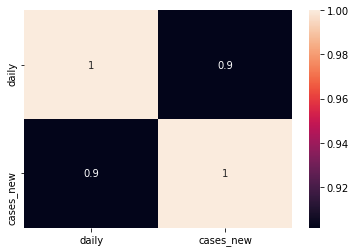

In [66]:
sns.heatmap(corr_selangor, annot=True)

In [67]:
corr_sabah = cases_vax_corr('Sabah')
corr_sabah

,daily,cases_new
daily,1.00000,0.87096
cases_new,0.87096,1.00000


<AxesSubplot:>

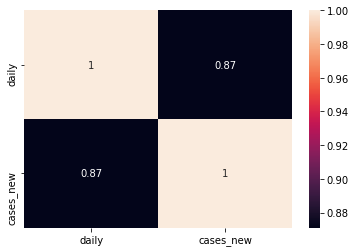

In [68]:
sns.heatmap(corr_sabah, annot=True)

In [69]:
corr_sarawak = cases_vax_corr('Sarawak')
corr_sarawak

,daily,cases_new
daily,1.000000,-0.181897
cases_new,-0.181897,1.000000


<AxesSubplot:>

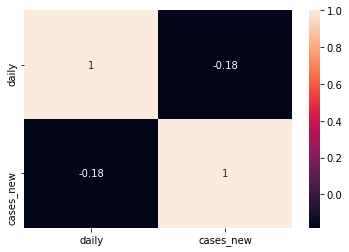

In [70]:
sns.heatmap(corr_sarawak, annot=True)

## Do the performance of states based on cases, deaths and vaccinations form any clusters?

In [71]:
warnings.filterwarnings('ignore')

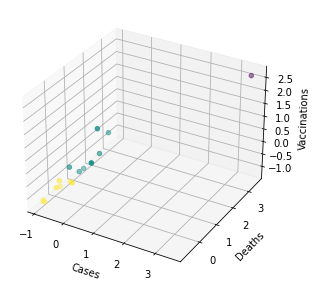

In [72]:
states = list(cases_state['state'].unique())

cases = []
vaccinations = []
deaths = []

for state in states:
    cases.append(cases_state[cases_state['state'] == state]['cases_new'].sum())
    deaths.append(deaths_state[deaths_state['state'] == state]['deaths_new'].sum())
    vaccinations.append(vax_state[deaths_state['state'] == state]['daily_full'].sum())

cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths, "vaccinations": vaccinations})
for col in cases_deaths_vaccinations:
    if cases_deaths_vaccinations[col].dtype != 'object':
        cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
X_std = cases_deaths_vaccinations

km = KMeans(n_clusters=3, max_iter=100)
y_clusters = km.fit_predict(cases_deaths_vaccinations)
centroids = km.cluster_centers_

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], cases_deaths_vaccinations['vaccinations'], c=y_clusters, cmap='viridis')
ax.set_xlabel('Cases')
ax.set_ylabel('Deaths')
ax.set_zlabel('Vaccinations')
plt.show()


In [73]:
cases_state

,date,state,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
0,2020-01-25,Johor,4,4,0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2020-01-25,Kedah,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-25,Kelantan,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,Melaka,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-25,Negeri Sembilan,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,2021-10-09,Selangor,1351,2,2271,16168,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9980,2021-10-09,Terengganu,590,0,1098,6641,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9981,2021-10-09,W.P. Kuala Lumpur,288,5,297,3286,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9982,2021-10-09,W.P. Labuan,1,0,1,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## How did the clusters change over time with respect to cases and deaths alone? Did some states reorganise into new clusters?

### KMeans

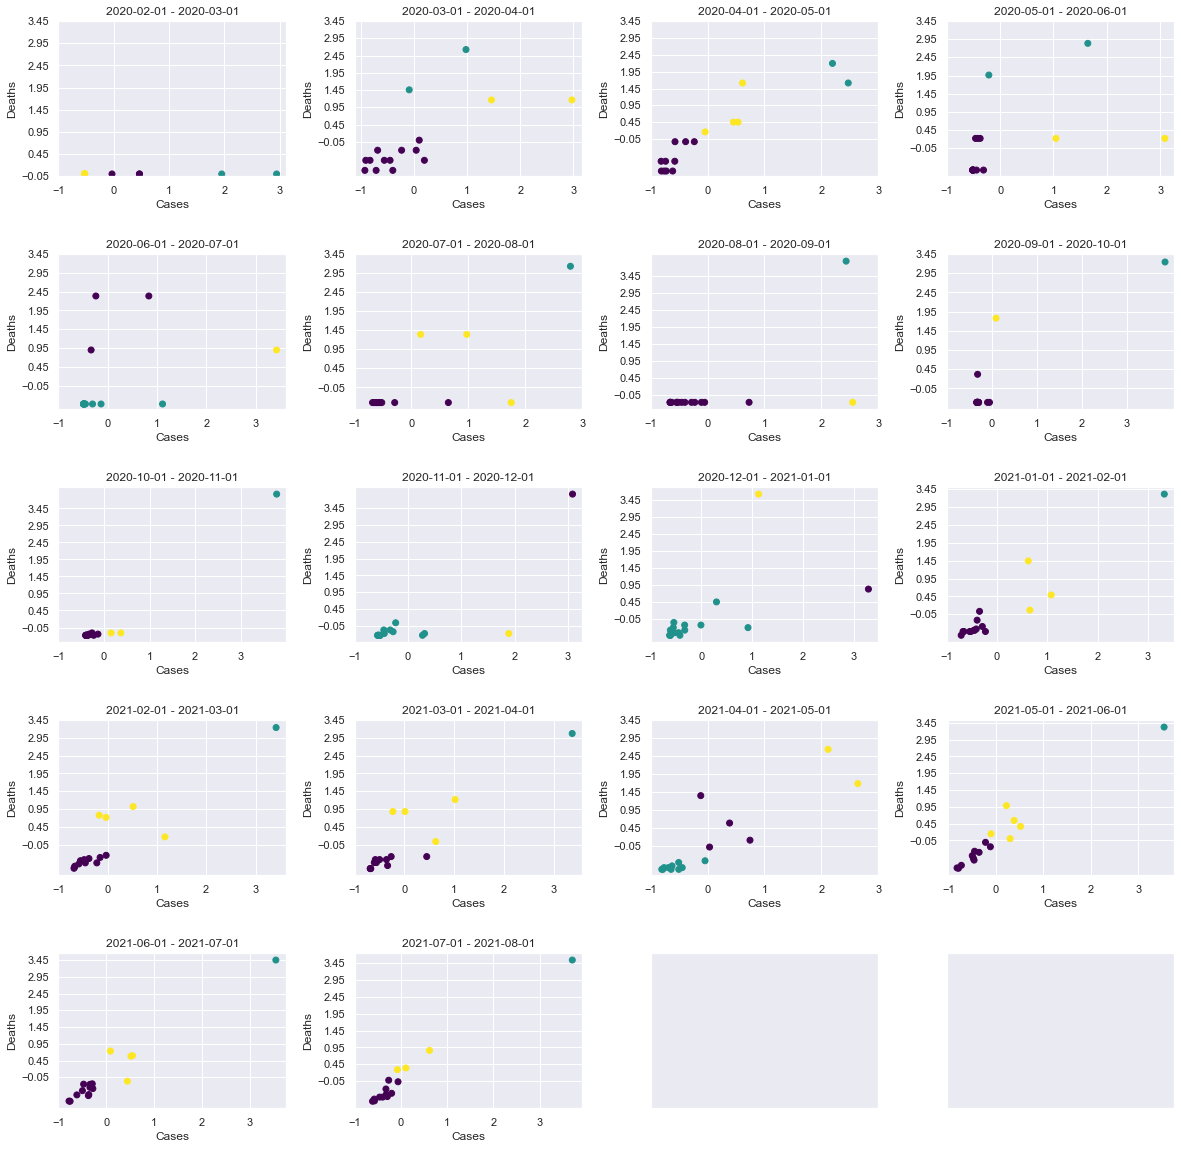

In [74]:
sns.set(rc={'figure.figsize':(18, 3)})
nrows = 5
ncols = 4
fig, axes = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    
    cases = []
    vaccinations = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum())

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths})
    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    km = KMeans(n_clusters=3, max_iter=100)
    y_clusters = km.fit_predict(cases_deaths_vaccinations)
    centroids = km.cluster_centers_

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num)
    ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Cases')
    ax.set_ylabel('Deaths')
    ax.set_xticks(np.arange(-1, 4, 1))
    ax.set_yticks(np.arange(-0.05, 3.5, 0.5))
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

### DBSCAN

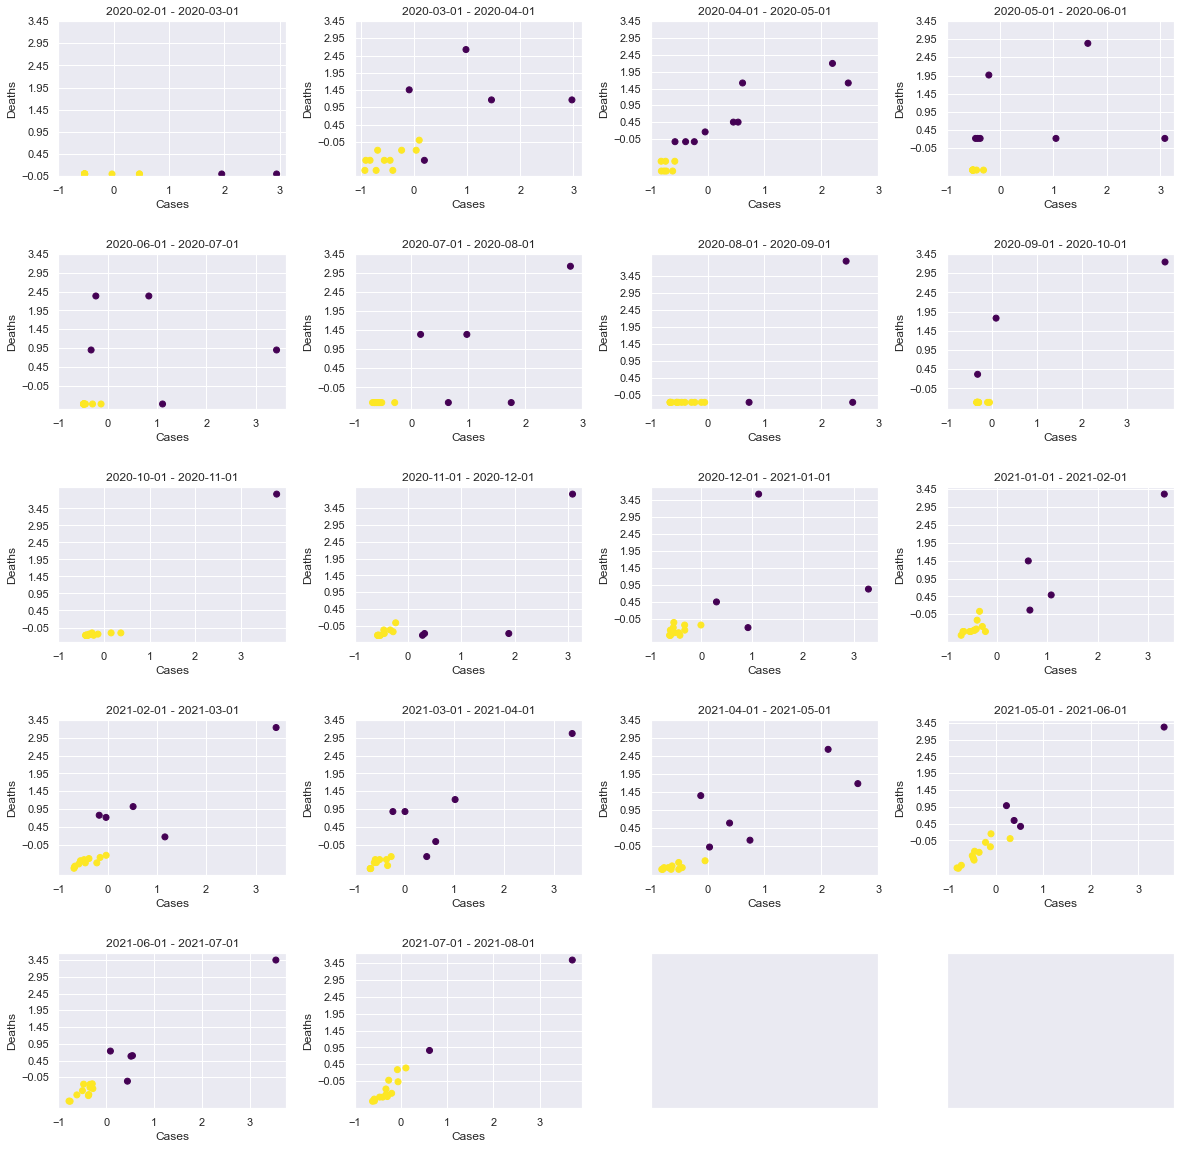

In [75]:
nrows = 5
ncols = 4
fig, axes = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    
    cases = []
    vaccinations = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum())

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths})
    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    dbscan = DBSCAN(eps=0.5, min_samples=5).fit(cases_deaths_vaccinations)
    y_clusters = dbscan.fit_predict(cases_deaths_vaccinations)

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num)
    ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Cases')
    ax.set_ylabel('Deaths')
    ax.set_xticks(np.arange(-1, 4, 1))
    ax.set_yticks(np.arange(-0.05, 3.5, 0.5))
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

We can observe that in the beginning, the majority of the clusters were positioned towards the bottom left and they maintain a similar pattern until about August 2020. In August, the cases were still high but there were fewer deaths, which may signify that the situation was improving, besides the one state that is in the upper corner of the plot that stands out from the rest. Around December, the bottom-right cluster begins to break up and states start moving diagonally upwards in the graph, meaning higher number of deaths and more cases. By September 2021, the states fall in a sort of straight diagonal line, with the performance of states spread across the spectrum from mild to serious. 

We also set out to find that one state that created a cluster of it's own throughout and it was Selangor, to no one's surprise.

## How did the clusters change over time with respect to cases, deaths and vaccinations? Did some states reorganise into new clusters?

In this question, we bring in a third factor: vaccinations.

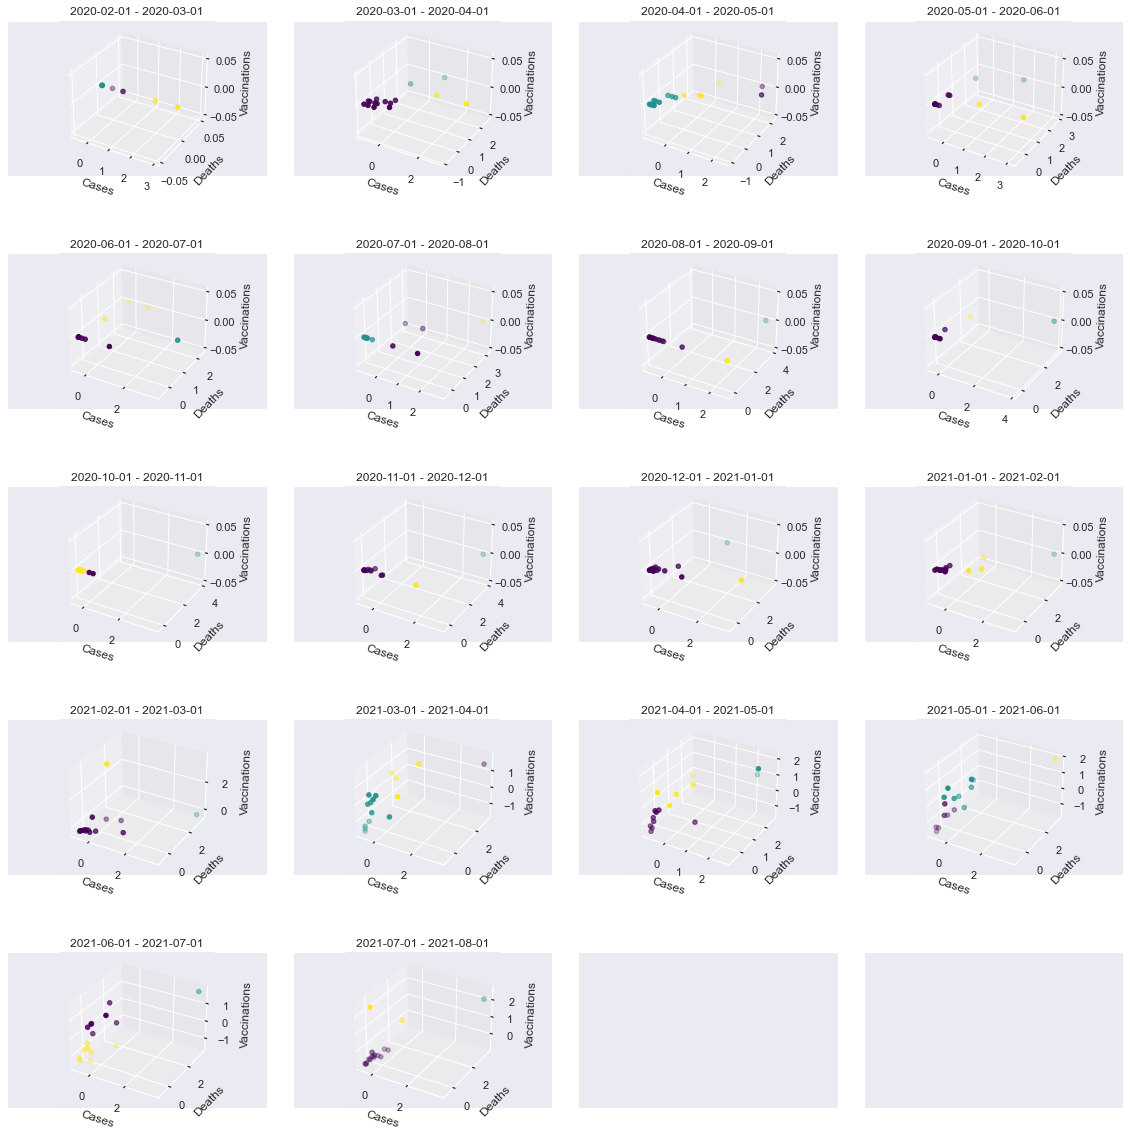

In [76]:
sns.set(rc={'figure.figsize':(18, 3)})
nrows = 5
ncols = 4
fig, axes = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    vax_state_date = vax_state[(vax_state['date'] >= date_range[0]) & (vax_state['date'] < date_range[1])]
    
    cases = []
    vaccinations = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum())
        vaccinations.append(vax_state_date[vax_state_date['state'] == state]['daily_full'].sum())

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths, "vaccinations": vaccinations})
    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    km = KMeans(n_clusters=3, max_iter=100)
    y_clusters = km.fit_predict(cases_deaths_vaccinations)
    centroids = km.cluster_centers_

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num, projection='3d')
    ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], cases_deaths_vaccinations['vaccinations'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Cases')
    ax.set_ylabel('Deaths')
    ax.set_zlabel('Vaccinations')
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

## Which states require attention in terms of their vaccination campaign and deaths?

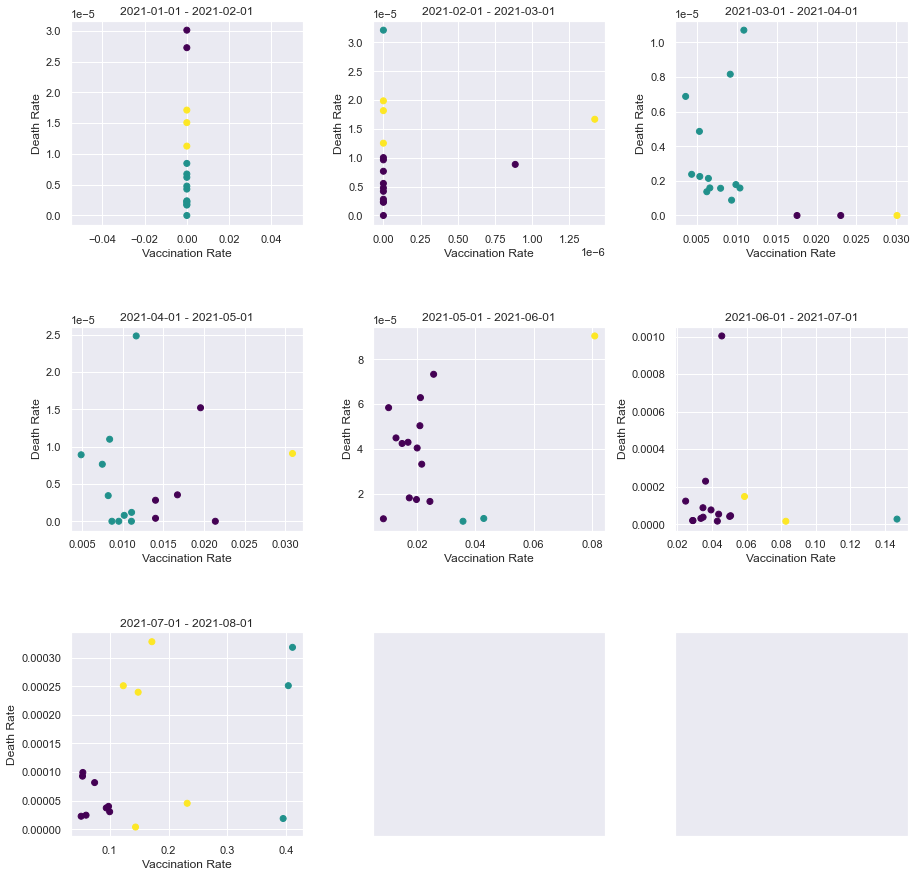

In [77]:
sns.set(rc={'figure.figsize':(18, 3)})
nrows = 3
ncols = 3
fig, axes = plt.subplots(3, 3, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    vax_state_date = vax_state[(vax_state['date'] >= date_range[0]) & (vax_state['date'] < date_range[1])]

    cases = []
    vaccination_rates = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum() / population.loc[population['state'] == state, 'pop'].values[0])
        # divide number of vaccinations by state population
        vaccination_rates.append(vax_state_date[vax_state_date['state'] == state]['daily_full'].sum() / population.loc[population['state'] == state, 'pop'].values[0])

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "deaths": deaths, "vaccination_rate": vaccination_rates})
    # for col in cases_deaths_vaccinations:
    #     if cases_deaths_vaccinations[col].dtype != 'object':
    #         cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    km = KMeans(n_clusters=3, max_iter=100)
    y_clusters = km.fit_predict(cases_deaths_vaccinations)
    centroids = km.cluster_centers_

    # put back state column
    cases_deaths_vaccinations['state'] = states

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num)
    ax.scatter(cases_deaths_vaccinations['vaccination_rate'], cases_deaths_vaccinations['deaths'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Vaccination Rate')
    ax.set_ylabel('Death Rate')
    # ax.set_xticks(np.arange(-0.5, 0.5, 0.1))
    # ax.set_yticks(np.arange(-0.05, 3.5, 0.5))
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

In [78]:
cases_deaths_vaccinations[y_clusters == 1]

,deaths,vaccination_rate,state
10,0.000019,0.394775,Sarawak
13,0.000318,0.410651,W.P. Kuala Lumpur
14,0.000251,0.403524,W.P. Labuan


We can see that throughout 2020, there are 0 vaccinations in all state since the vaccination campaign was yet to start. By February 2021, two states have begun their vaccination campaigns. It speeds up more rapidly by March and April, the vertical clusters start to spread out on the x-axis indicating higher vaccination numbers. In June 2021, there was a remarkable shoot where the y-axis scale completely changed. As of September 2021, the states that may require attention are those with low vaccination rates and high deaths, namely cluster 2, which contains the following states:
1. Melaka
2. Negeri Sembilan
3. Perlis
4. Selangor
5. W.P. Putrajaya

On the other hand, these are the states with relatively high vaccination rates w.r.t deaths:
1. Sarawak
2. W.P. Kuala Lumpur
3. W.P. Labuan

## Which Covid clusters have been the most drastic?

In [79]:
# iterate row by row through clusters dataframe
clusters['single_state'] = clusters['state'].apply(lambda x: [state.strip().title() for state in re.split(', | & ', x)])
clusters_singlestate = clusters.explode('single_state')

NameError: name 're' is not defined

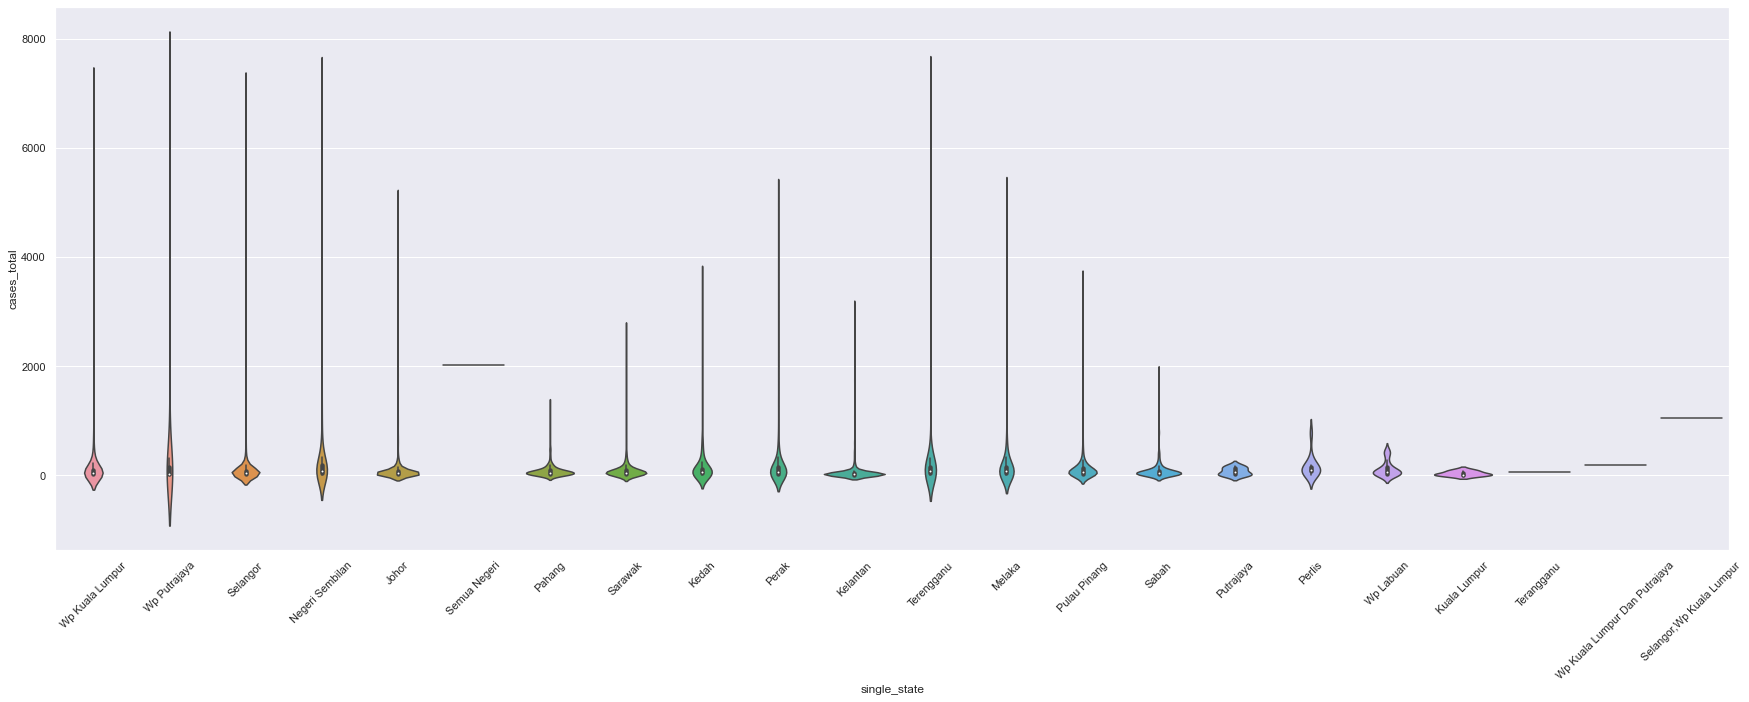

In [ ]:
plt.figure(figsize=(30, 10))
sns.violinplot(x='single_state', y='cases_total', data=clusters_singlestate)
plt.xticks(rotation=45)
plt.show()

### MeanShift

<AxesSubplot:xlabel='tests', ylabel='cases_total'>

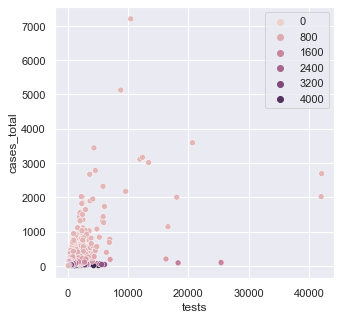

In [ ]:
from sklearn.cluster import MeanShift

ms = MeanShift(bandwidth=0.5)
ms.fit(clusters[['cases_total', 'tests']])
cluster_centers = ms.cluster_centers_
cluster_predictions = ms.predict(clusters[['cases_total', 'tests']])

plt.figure(figsize=(5, 5))
sns.scatterplot(data=clusters, x='tests', y='cases_total', hue=cluster_predictions)

### KMeans

<AxesSubplot:xlabel='tests', ylabel='cases_total'>

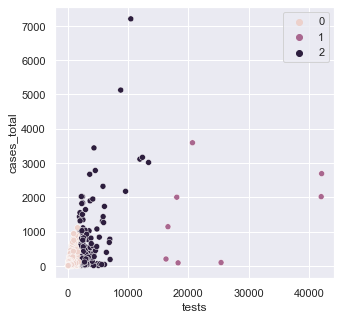

In [ ]:
km = KMeans(n_clusters=3, max_iter=100)
y_clusters = km.fit_predict(clusters[['cases_total', 'tests']])
centroids = km.cluster_centers_

plt.figure(figsize=(5, 5))
sns.scatterplot(data=clusters, x='tests', y='cases_total', hue=y_clusters)

talk about clusters here

## Does the current vaccination rate allow herd immunity to be achieved by 30 November 2021? You can assume that herd immunity can be achieved with 80% of the population having been vaccinated. 

In [ ]:
# vax_population = vax_malaysia.merge(population, on='state')
malaysia_population = population[population['state'] == 'Malaysia']['pop'].iloc[0]
vax_malaysia['cumul'] = vax_malaysia['daily_full'].cumsum()
vax_malaysia['percentage_vaccinated'] = vax_malaysia['cumul'] / malaysia_population

<AxesSubplot:xlabel='date'>

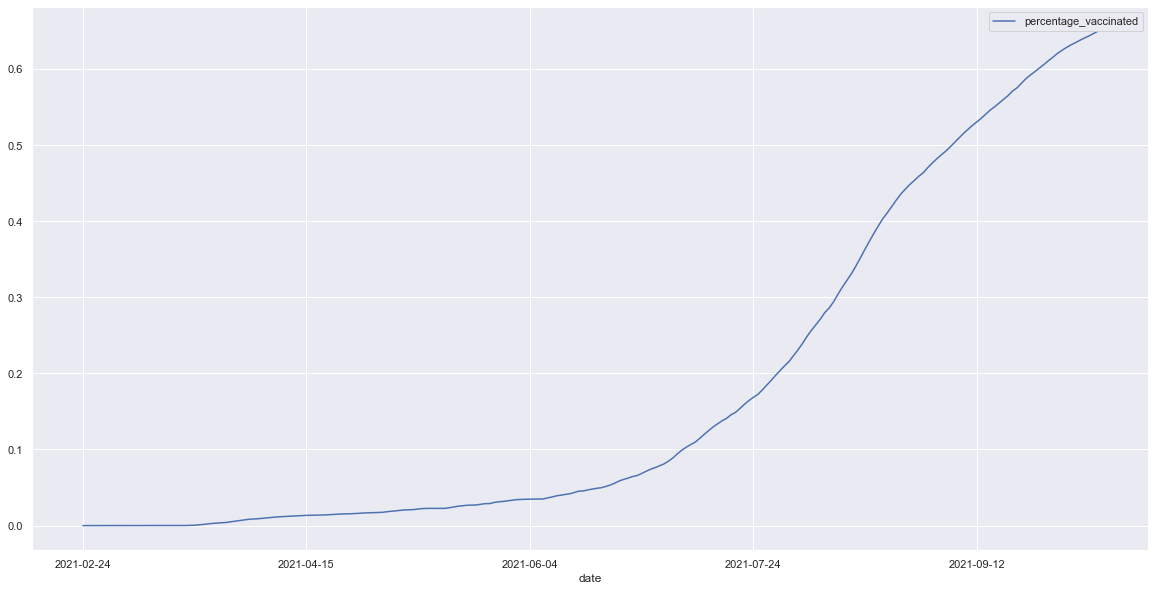

In [ ]:
vax_malaysia.plot.line(x='date', y='percentage_vaccinated', figsize=(20,10))

## Can Malaysia reach herd immunity by 30 November 2021?

<AxesSubplot:>

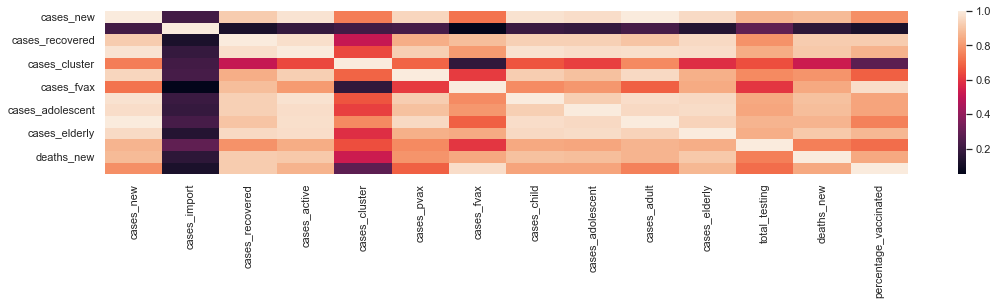

In [ ]:
cases_testing_deaths_vax = cases_malaysia.merge(tests_malaysia, on='date')
cases_testing_deaths_vax = cases_testing_deaths_vax.merge(deaths_malaysia, on='date')
cases_testing_deaths_vax = cases_testing_deaths_vax.merge(vax_malaysia[['date', 'percentage_vaccinated']], on='date')
sns.heatmap(cases_testing_deaths_vax.corr())

Select best features using Boruta

In [ ]:
X = cases_testing_deaths_vax.drop(columns=['date','percentage_vaccinated'])
y = cases_testing_deaths_vax['percentage_vaccinated']

rf = RandomForestRegressor(n_jobs=-1, max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X.values, y.ravel())

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	1
Iteration: 	10 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	1
Iteration: 	11 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	2


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	2


array([1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1])

In [ ]:
# chosen features
accept = X.columns[feat_selector.support_].to_list()
# transform dataframe to only selected features
filtered = pd.DataFrame(feat_selector.transform(X.values), columns=accept)
# add back date and percentage vaccinated
filtered['percentage_vaccinated'] = y
filtered['date'] = cases_testing_deaths_vax['date']
filtered['date'] = pd.to_datetime(filtered['date'])
filtered.set_index('date', inplace=True)

In [ ]:
filtered

,cases_new,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,deaths_new,percentage_vaccinated
date,,,,,,,,,,,,
2021-02-24,3545.0,3331.0,30572.0,2483.0,0.0,0.0,145.0,84.0,2919.0,173.0,12.0,0.000000e+00
2021-02-25,1924.0,3752.0,28738.0,705.0,0.0,0.0,158.0,72.0,1473.0,155.0,13.0,0.000000e+00
2021-02-26,2253.0,3085.0,27903.0,1136.0,0.0,0.0,124.0,75.0,1822.0,173.0,10.0,3.062093e-08
2021-02-27,2364.0,3320.0,26937.0,1100.0,0.0,0.0,147.0,100.0,1858.0,162.0,10.0,6.124186e-08
2021-02-28,2437.0,3251.0,26118.0,1404.0,0.0,0.0,132.0,83.0,2044.0,113.0,9.0,1.531047e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-02,10915.0,15396.0,155499.0,656.0,1306.0,5885.0,1951.0,938.0,6756.0,1166.0,109.0,6.280795e-01
2021-10-03,9066.0,14454.0,150019.0,388.0,1124.0,4944.0,1700.0,764.0,5348.0,1087.0,118.0,6.314647e-01
2021-10-04,8075.0,15456.0,142562.0,731.0,1097.0,4287.0,1353.0,641.0,5050.0,948.0,76.0,6.343853e-01


In [ ]:
train_df, test_df = filtered[1:168], filtered[168:]

In [ ]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

NameError: name 'MinMaxScaler' is not defined

In [ ]:
def split_series(series, n_past, n_future):
      #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 10
n_future = 5 
n_features = 7

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

ValueError: cannot reshape array of size 18360 into shape (153,10,7)

In [ ]:
top_80 = round(0.75 * len(filtered))

training_set = filtered.iloc[:top_80, :].values
testing_set = filtered.iloc[top_80:, :].values

# sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = training_set.copy()
# training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# everything but the last column that is percentage vaccinated
num_features = len(filtered.columns[:-1])

In [ ]:
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, :-1])
    y_train.append(training_set_scaled[i, -1])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

(109, 60, 11)


In [ ]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], num_features)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
4/4 [==============================] - 6s 101ms/step - loss: 0.0281
Epoch 2/30
4/4 [==============================] - 0s 93ms/step - loss: 0.0133
Epoch 3/30
4/4 [==============================] - 0s 82ms/step - loss: 0.0102
Epoch 4/30
4/4 [==============================] - 0s 85ms/step - loss: 0.0084
Epoch 5/30
4/4 [==============================] - 0s 85ms/step - loss: 0.0072
Epoch 6/30
4/4 [==============================] - 0s 84ms/step - loss: 0.0082
Epoch 7/30
4/4 [==============================] - 0s 82ms/step - loss: 0.0071
Epoch 8/30
4/4 [==============================] - 0s 88ms/step - loss: 0.0066
Epoch 9/30
4/4 [==============================] - 0s 86ms/step - loss: 0.0061
Epoch 10/30
4/4 [==============================] - 0s 85ms/step - loss: 0.0055
Epoch 11/30
4/4 [==============================] - 0s 84ms/step - loss: 0.0059
Epoch 12/30
4/4 [==============================] - 0s 84ms/step - loss: 0.0060
Epoch 13/30
4/4 [==============================] - 0s 84ms/s

In [ ]:
testing_set_scaled = testing_set.copy()
# testing_set_scaled[:-1] = sc.transform(testing_set_scaled[:-1])
# testing_set_scaled = sc.transform(testing_set)
X_test = []
y_test = []
for i in range(50, len(testing_set_scaled)):
    X_test.append(testing_set_scaled[i-50:i, :-1])
    y_test.append(testing_set_scaled[i, -1])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape

(6, 50, 11)

In [ ]:
predicted_vac_rate = model.predict(X_test)
predicted_vac_rate
# predicted_vac_rate = sc.inverse_transform(predicted_vac_rate)

array([[0.07698549],
       [0.07698549],
       [0.07698549],
       [0.07698549],
       [0.07698549],
       [0.07698549]], dtype=float32)

In [ ]:
y_test

array([0.62434921, 0.62807952, 0.63146466, 0.63438525, 0.63750495,
       0.64045882])

In [ ]:
filtered['percentage_vaccinated']

0      0.000000e+00
1      0.000000e+00
2      3.062093e-08
3      6.124186e-08
4      1.531047e-07
           ...     
220    6.280795e-01
221    6.314647e-01
222    6.343853e-01
223    6.375049e-01
224    6.404588e-01
Name: percentage_vaccinated, Length: 225, dtype: float64

In [ ]:
# def split_series(series, n_past, n_future):
#   X, y = list(), list()
#   for window_start in range(len(series)):
#     past_end = window_start + n_past
#     future_end = past_end + n_future
#     if future_end > len(series):
#       break
#     # slicing the past and future parts of the window
#     past, future = series[window_start:past_end, :], series[past_end:future_end, :]
#     X.append(past)
#     y.append(future)
#   return np.array(X), np.array(y)

In [ ]:
# num_rows = len(X_filtered)
# top_75_per = int(0.75 * num_rows)
# bottom_25_per = num_rows - top_75_per

# X_train = X_filtered[1:top_75_per]

# y_train = y[1:top_75_per]

# X_test = X_filtered[top_75_per:]

# y_test = y[top_75_per:]

In [ ]:
X_train

NameError: name 'X_train' is not defined

## Has vaccination helped reduce the daily cases? What states have shown the effect of vaccination?

### How well is Malaysia's vaccination campaign doing compared to other countries in Asia?

In [ ]:
global_datasets =  pd.read_csv('./global_datasets/owid-covid-data.csv')
global_datasets

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124194,ZWE,Africa,Zimbabwe,2021-10-12,132016.0,141.0,115.857,4645.0,2.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
124195,ZWE,Africa,Zimbabwe,2021-10-13,132108.0,92.0,96.286,4648.0,3.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
124196,ZWE,Africa,Zimbabwe,2021-10-14,132251.0,143.0,104.000,4655.0,7.0,3.429,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
124197,ZWE,Africa,Zimbabwe,2021-10-15,132285.0,34.0,82.857,4655.0,0.0,3.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [ ]:
global_datasets.isna().sum()

iso_code                                        0
continent                                    5632
location                                        0
date                                            0
total_cases                                  6661
                                            ...  
human_development_index                     14348
excess_mortality_cumulative_absolute       119705
excess_mortality_cumulative                119705
excess_mortality                           119705
excess_mortality_cumulative_per_million    119705
Length: 65, dtype: int64

In [ ]:
global_datasets.fillna(0, inplace=True)
global_datasets.isna().sum()

iso_code                                   0
continent                                  0
location                                   0
date                                       0
total_cases                                0
                                          ..
human_development_index                    0
excess_mortality_cumulative_absolute       0
excess_mortality_cumulative                0
excess_mortality                           0
excess_mortality_cumulative_per_million    0
Length: 65, dtype: int64

In [ ]:
global_datasets.drop_duplicates()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,0.000,0.0,0.0,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124194,ZWE,Africa,Zimbabwe,2021-10-12,132016.0,141.0,115.857,4645.0,2.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,0.0,0.0,0.0,0.0
124195,ZWE,Africa,Zimbabwe,2021-10-13,132108.0,92.0,96.286,4648.0,3.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,0.0,0.0,0.0,0.0
124196,ZWE,Africa,Zimbabwe,2021-10-14,132251.0,143.0,104.000,4655.0,7.0,3.429,...,1.6,30.7,36.791,1.7,61.49,0.571,0.0,0.0,0.0,0.0
124197,ZWE,Africa,Zimbabwe,2021-10-15,132285.0,34.0,82.857,4655.0,0.0,3.000,...,1.6,30.7,36.791,1.7,61.49,0.571,0.0,0.0,0.0,0.0


In [ ]:
list(global_datasets.columns)

['iso_code',
 'continent',
 'location',
 'date',
 'total_cases',
 'new_cases',
 'new_cases_smoothed',
 'total_deaths',
 'new_deaths',
 'new_deaths_smoothed',
 'total_cases_per_million',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'reproduction_rate',
 'icu_patients',
 'icu_patients_per_million',
 'hosp_patients',
 'hosp_patients_per_million',
 'weekly_icu_admissions',
 'weekly_icu_admissions_per_million',
 'weekly_hosp_admissions',
 'weekly_hosp_admissions_per_million',
 'new_tests',
 'total_tests',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed',
 'new_tests_smoothed_per_thousand',
 'positive_rate',
 'tests_per_case',
 'tests_units',
 'total_vaccinations',
 'people_vaccinated',
 'people_fully_vaccinated',
 'total_boosters',
 'new_vaccinations',
 'new_vaccinations_smoothed',
 'total_vaccinations_per_hundred',
 'people_vaccinated_per_hundred',
 'peo

In [ ]:
global_datasets.drop(columns=['iso_code', 'continent','new_cases_smoothed','new_deaths_smoothed','new_cases_smoothed_per_million',
                              'new_deaths_smoothed_per_million','reproduction_rate','icu_patients','icu_patients_per_million','hosp_patients',
                              'hosp_patients_per_million','weekly_icu_admissions','weekly_icu_admissions_per_million','weekly_hosp_admissions',
                              'weekly_hosp_admissions_per_million','new_tests_smoothed','total_boosters','new_vaccinations_smoothed',
                              'total_boosters_per_hundred','new_vaccinations_smoothed_per_million','stringency_index','median_age',
                              'aged_65_older','aged_70_older','gdp_per_capita','extreme_poverty','cardiovasc_death_rate','diabetes_prevalence',
                              'female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','life_expectancy','human_development_index',
                              'excess_mortality_cumulative_absolute','excess_mortality_cumulative','excess_mortality','excess_mortality_cumulative_per_million',
                             ], inplace=True)
global_datasets.head()

,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,...,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,population,population_density
0,Afghanistan,2020-02-24,5.0,5.0,0.0,0.0,0.126,0.126,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
1,Afghanistan,2020-02-25,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
2,Afghanistan,2020-02-26,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
3,Afghanistan,2020-02-27,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
4,Afghanistan,2020-02-28,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422


In [ ]:
def getCountry(country) :
    filter = global_datasets['location'] == country
    df = global_datasets[filter]
    df = df[['date','population','people_fully_vaccinated']]
    df['cumul'] = df['people_fully_vaccinated'].cumsum()
    df['percentage_vaccinated'] = df['cumul'] / df['population']
    filter2 = df['date'] > '2021-04'
    df = df[filter2]
    return df

In [ ]:
Brunei = getCountry('Brunei')
Myanmar = getCountry('Myanmar')
Cambodia = getCountry('Cambodia')
Indonesia = getCountry('Indonesia')
Laos = getCountry('Laos')
Malaysia = getCountry('Malaysia')
Philippines = getCountry('Philippines')
Singapore = getCountry('Singapore')
Thailand = getCountry('Thailand')
Vietnam = getCountry('Vietnam')

In [ ]:
Singapore

,date,population,people_fully_vaccinated,cumul,percentage_vaccinated
99933,2021-04-02,5896684.0,0.0,2209503.0,0.374703
99934,2021-04-03,5896684.0,468000.0,2677503.0,0.454069
99935,2021-04-04,5896684.0,0.0,2677503.0,0.454069
99936,2021-04-05,5896684.0,0.0,2677503.0,0.454069
99937,2021-04-06,5896684.0,535864.0,3213367.0,0.544945
...,...,...,...,...,...
100126,2021-10-12,5896684.0,4668668.0,282148437.0,47.848662
100127,2021-10-13,5896684.0,4671695.0,286820132.0,48.640920
100128,2021-10-14,5896684.0,4674723.0,291494855.0,49.433691
100129,2021-10-15,5896684.0,4678127.0,296172982.0,50.227040


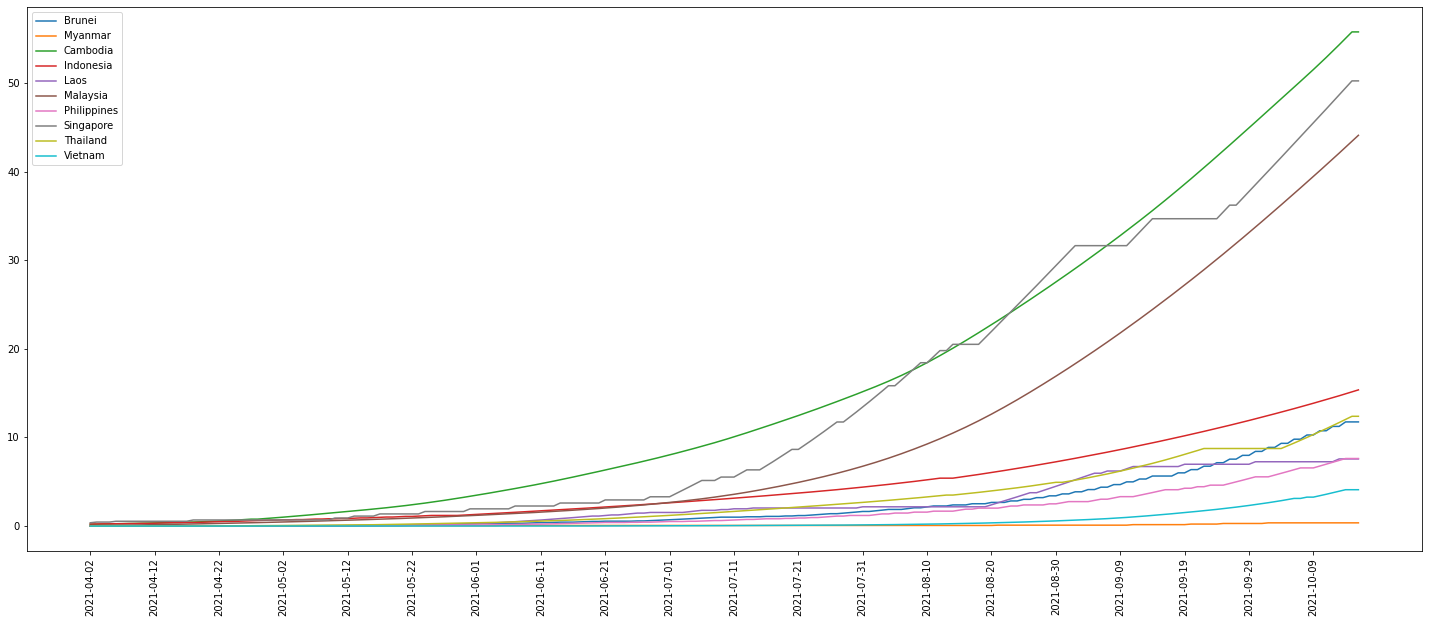

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(Brunei['date'], Brunei['percentage_vaccinated'], label = "Brunei")
ax.plot(Myanmar['date'], Myanmar['percentage_vaccinated'], label = "Myanmar")
ax.plot(Cambodia['date'], Cambodia['percentage_vaccinated'], label = "Cambodia")
ax.plot(Indonesia['date'], Indonesia['percentage_vaccinated'], label = "Indonesia")
ax.plot(Laos['date'], Laos['percentage_vaccinated'], label = "Laos")
ax.plot(Malaysia['date'], Malaysia['percentage_vaccinated'], label = "Malaysia")
ax.plot(Philippines['date'], Philippines['percentage_vaccinated'], label = "Philippines")
ax.plot(Singapore['date'], Singapore['percentage_vaccinated'], label = "Singapore")
ax.plot(Thailand['date'], Thailand['percentage_vaccinated'], label = "Thailand")
ax.plot(Vietnam['date'], Vietnam['percentage_vaccinated'], label = "Vietnam")
ax.set_xticks(ax.get_xticks()[::10])
ax.tick_params(axis='x', labelrotation=90)
ax.legend()

### Is there a link between traces_malaysia casual_contacts and daily cases? Can we classify how contagious Covid is?

In [81]:
trace_malaysia = pd.read_csv('./cases/mysejahtera/trace_malaysia.csv')
trace_malaysia

,date,casual_contacts,hide_large,hide_small
0,2021-03-01,7847,NaN,NaN
1,2021-03-02,6419,NaN,NaN
2,2021-03-03,6903,NaN,NaN
3,2021-03-04,7000,NaN,NaN
4,2021-03-05,9152,NaN,NaN
...,...,...,...,...
216,2021-10-03,32301,37.0,604.0
217,2021-10-05,37312,39.0,841.0
218,2021-10-06,34444,45.0,782.0
219,2021-10-07,39312,43.0,820.0


In [82]:
trace_malaysia.isna().sum()

date                0
casual_contacts     0
hide_large         50
hide_small         50
dtype: int64

In [83]:
trace_malaysia.fillna(0,inplace=True)

In [84]:
trace_malaysia.drop_duplicates()

,date,casual_contacts,hide_large,hide_small
0,2021-03-01,7847,0.0,0.0
1,2021-03-02,6419,0.0,0.0
2,2021-03-03,6903,0.0,0.0
3,2021-03-04,7000,0.0,0.0
4,2021-03-05,9152,0.0,0.0
...,...,...,...,...
216,2021-10-03,32301,37.0,604.0
217,2021-10-05,37312,39.0,841.0
218,2021-10-06,34444,45.0,782.0
219,2021-10-07,39312,43.0,820.0


In [85]:
temp_cases_malaysia = cases_malaysia.copy()
temp_trace_malaysia = trace_malaysia.copy()

In [86]:
merged = temp_cases_malaysia.merge(temp_trace_malaysia, on='date')
corr = merged[['casual_contacts', 'cases_new']].corr()
corr

,casual_contacts,cases_new
casual_contacts,1.000000,0.761866
cases_new,0.761866,1.000000


<AxesSubplot:>

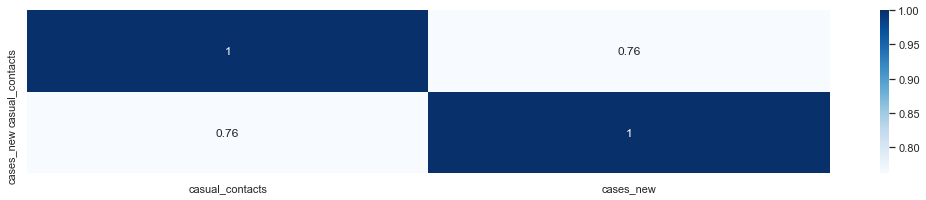

In [87]:
sns.heatmap(corr, annot=True,cmap='Blues')